1. Взять любой набор данных для бинарной классификации
2. Обучить любой классификатор 
3. Разделить набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные примеры (класс 1), а только лишь часть
4. Применить random negative sampling для построения классификатора в новых условиях
5. Сравнить качество с решением из пункта 3 (построить отчет - таблицу метрик)
6. *Поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

_____

Датасет лежит [здесь](https://www.kaggle.com/datasets/joshmcadams/oranges-vs-grapefruit) - это данные о диаметре, весе и цвете апельсинов и грейпфрутов. Нужно отделить одних от других

In [1]:
#!curl -O https://www.kaggle.com/datasets/joshmcadams/oranges-vs-grapefruit/download?datasetVersionNumber=2

In [2]:
#!pip install xgboost

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score

In [4]:
def evaluate_results(y_test, y_predict, show_info=False, get_info=False):
    """метрики: F1-score, precision, recall"""

    F1 = f1_score(y_test, y_predict)
    rec = recall_score(y_test, y_predict, average='binary')
    prc = precision_score(y_test, y_predict, average='binary')

    if show_info:
        print('-------\nРезультаты классификации:\n'
              f'F1: {F1:.2%}\nrecall: {rec:.2%}\nprecision: {prc:.2%}')
    if get_info:
        return prc, rec, F1


def look_alike_algorithm(X_train, y_train, model=xgb.XGBClassifier(), perc=0.25, show_info=False):
    """реализация look-alike обучения"""

    # забираем для обучения perc% таргета=1
    mod_data = X_train.copy()
    mod_data['name'] = y_train
    mod_data = mod_data.reset_index(drop=True)
    pos_ind = np.where(mod_data.iloc[:, -1].values == 1)[0]
    np.random.shuffle(pos_ind)
    pos_sample_len = int(np.ceil(perc * len(pos_ind)))

    # создаём новую целевую переменную
    pos_sample = pos_ind[:pos_sample_len]
    mod_data['class_test'] = -1
    mod_data.loc[pos_sample, 'class_test'] = 1

    # этап Random Negative Sample
    mod_data = mod_data.sample(frac=1)

    data_N = mod_data[mod_data['class_test'] == -1]
    data_P = mod_data[mod_data['class_test'] == 1]

    neg_sample = data_N[:data_P.shape[0]]
    sample_test = data_N[data_P.shape[0]:]
    pos_sample = data_P.copy()

    sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

    # предсказываем:
    model = xgb.XGBClassifier()
    sample_train.loc[sample_train['class_test'] == -1, 'class_test'] = 0

    model.fit(sample_train.drop(columns=['class_test', 'name']),
              sample_train['class_test'])
    predict = model.predict(X_test)

    if show_info:
        print(f'использовано {pos_sample_len/len(pos_ind):.0%} признаков целевой переменной, '
              'с остальных метки сняты'
              f'\n\nраспределение признака:\n{pd.DataFrame(mod_data.iloc[:,-1].value_counts())}'
              f'\n\nразмеры:\n{neg_sample.shape=}\n{pos_sample.shape=}')

    return predict


result_table = pd.DataFrame(columns=['name_model', 'precision', 'recall', 'F1-score'])


def add_table(name_model, precision, recall, F1, result_table):
    """функция дозаписывает таблицу"""

    result_table = pd.concat([result_table,
                              pd.DataFrame({'name_model': name_model,
                                            'precision': precision,
                                            'recall': recall,
                                            'F1-score': F1}, index=[0])],
                             ignore_index=True)
    return result_table


def get_plot():
    """функция отрисовывает три plot-графика"""

    fig, ax = plt.subplots(nrows=3, figsize=(10, 8))
    title_list = ['precision', 'recall', 'F1_score']
    fig.suptitle('зависимость метрик от доли True-значений', fontsize=16, fontweight='bold')
    for i, p in enumerate([prec_list, rec_list, f1_list]):
        ax[i].plot(p, '-o', ms=2, lw=0.5, c='#EC2591')
        ax[i].set_title(title_list[i], fontweight='bold', fontsize=13)
        ax[i].minorticks_on()
        ax[i].grid(which='major', linewidth=0.5)
        ax[i].grid(which='minor', axis='y', linewidth=0.25, linestyle='--')
        ax[i].set_xticks(np.arange(0, 55, 5))
        ax[i].set_xticklabels([1] + list(range(5, 100, 10)))
        ax[i].set_xlabel('доля True-значений', fontsize=7)
    plt.subplots_adjust(hspace=0.5);

Качаем датасет и смотрим на него:

In [5]:
df = pd.read_csv('citrus.csv')
df.head()

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      10000 non-null  object 
 1   diameter  10000 non-null  float64
 2   weight    10000 non-null  float64
 3   red       10000 non-null  int64  
 4   green     10000 non-null  int64  
 5   blue      10000 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 468.9+ KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
diameter,10000.0,9.975685,1.947844,2.96,8.46,9.980,11.4800,16.45
weight,10000.0,175.050792,29.212119,86.76,152.22,174.985,197.7225,261.51
red,10000.0,153.847800,10.432954,115.00,147.00,154.000,161.0000,192.00
green,10000.0,76.010600,11.708433,31.00,68.00,76.000,84.0000,116.00
blue,10000.0,11.363200,9.061275,2.00,2.00,10.000,17.0000,56.00


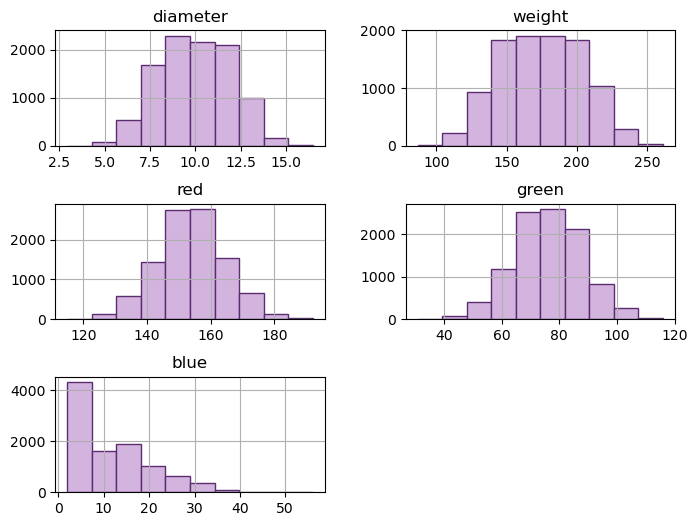

In [8]:
df.select_dtypes(include=np.number).hist(figsize=(8, 6), color='#D2B4DE', ec='#5B2C6F')
plt.subplots_adjust(hspace=0.5);

**Описание признаков:**

- ```name``` - бинарная целевая переменная - 'orange' or 'grapefruit'
- ```diameter``` - диаметр в сантиметрах
- ```weight``` - вес в раммах
- ```red``` - Среднее значение красного цвета при сканировании RGB. Значения должны быть от 0 до 255
- ```green``` - Среднее значение зеленого цвета при сканировании RGB. Значения должны быть от 0 до 255.
- ```blue``` - Среднее значение синего цвета при сканировании RGB. Значения должны быть от 0 до 255.

```RGB``` - это аббревиатура от Red (красный), Green (зеленый) и Blue (синий) - это три основных цвета, которые используются в электронной графике и фотографии для создания цветового спектра.

_____

Сделаем целевую переменную 0 (грейпфруты) и 1 (апельсины) и посмотрим на её распределение:

In [9]:
df['name'] = np.where(df['name'] == 'orange', 1, 0)
df['name'].value_counts()

1    5000
0    5000
Name: name, dtype: int64

Разобъём данные:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='name'),
                                                    df['name'], test_size=.2, random_state=0)

_____

 Сначала проверим, что получится с применением обычной классификации:

In [11]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
prec, rec, f1 = evaluate_results(y_test, y_predict, show_info=True, get_info=True)
result_table = add_table('обычная классификация', prec, rec, f1, result_table)

-------
Результаты классификации:
F1: 98.47%
recall: 97.67%
precision: 99.28%


_____

Теперь попробуем подход ```random negative sampling``` для построения модели, разделяя данные с помощью ```PU learning```-алгоритма:

Оставим от класса = 1 25%, а остальные признаки (и 0 и 1) отпределим как неразмеченные:

In [12]:
prec, rec, f1 = evaluate_results(y_test,
                                 look_alike_algorithm(X_train, y_train, perc=0.25, show_info=True),
                                 show_info=True, get_info=True)
result_table = add_table('PU learning 25%', prec, rec, f1, result_table)
result_table

использовано 25% признаков целевой переменной, с остальных метки сняты

распределение признака:
    class_test
-1        6997
 1        1003

размеры:
neg_sample.shape=(1003, 7)
pos_sample.shape=(1003, 7)
-------
Результаты классификации:
F1: 86.14%
recall: 78.64%
precision: 95.22%


,name_model,precision,recall,F1-score
0,обычная классификация,0.992798,0.976721,0.984694
1,PU learning 25%,0.952206,0.786437,0.861419


При применении PU learning- подхода мы видим небольшую просадку в значениях метрик. 

_____

Проведём эксперимент - будем метять % true-значений и посмотрим на изменение значений F1, precision и recall:

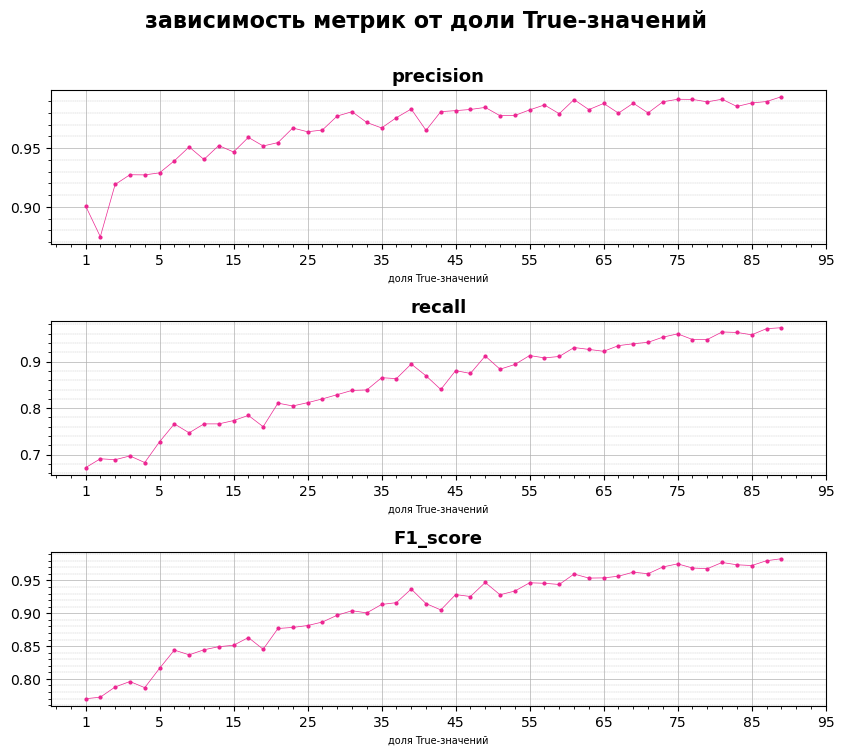

In [13]:
prec_list, rec_list, f1_list = [], [], []

frac, step = 0.05, 1
while frac < 1:
    y_pred = look_alike_algorithm(X_train, y_train, perc=frac)
    prec, rec, f1 = evaluate_results(y_test, y_pred, get_info=True)
    prec_list.append(prec)
    rec_list.append(rec)
    f1_list.append(f1)
    frac += 0.02
    step += 1
    if step % 5 == 0:
        result_table = add_table(f'PU learning {frac:.0%}', prec, rec, f1, result_table)
get_plot()

Отсортируем значение метрик по 'F1-score' и посмотрим на результат:

In [14]:
result_table.sort_values('F1-score', ascending=False).reset_index(drop=True)

,name_model,precision,recall,F1-score
0,обычная классификация,0.992798,0.976721,0.984694
1,PU learning 93%,0.991667,0.963563,0.977413
2,PU learning 83%,0.979979,0.941296,0.960248
3,PU learning 73%,0.991370,0.930162,0.959791
4,PU learning 63%,0.977604,0.883603,0.928230
5,PU learning 53%,0.965169,0.869433,0.914803
6,PU learning 43%,0.981043,0.838057,0.903930
7,PU learning 33%,0.954708,0.810729,0.876847
8,PU learning 25%,0.952206,0.786437,0.861419
9,PU learning 23%,0.940373,0.766194,0.844395


**Вывод:**

Очень логично и предсказуемо видно и в общей сводной таблице и на графиках то, что с увеличнием доли True-значений ```random negative sampling```-подход даёт качество всё лучше. Причём точность правильно предсказанных признаков страдает меньше всего, а вот полнота теряет аж до 30%.

В целом доля в 25-30% True-значений даёт хороший результат с F1 до 88% $\Rightarrow$ этот порог выглядит адекватным, можно остановиться на нём